In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 44100
overlap = 11025

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 3.157557249069214
(2535, 1, 44100)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 173, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 183ms/step - loss: 1457.3926
(1, 44100)


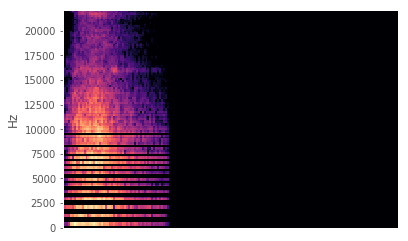

(2535, 128, 173)


In [17]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, 44100),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [20]:
frames = mfccs

In [21]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(2535, 128, 173, 1)

In [22]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 165, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 9, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                36896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

1723/1723 [==============================] - 7s 4ms/step - loss: 0.4560 - acc: 0.7806 - mean_absolute_error: 0.3244 - val_loss: 0.5982 - val_acc: 0.7443 - val_mean_absolute_error: 0.3560
Epoch 36/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.4544 - acc: 0.7702 - mean_absolute_error: 0.3177 - val_loss: 0.5795 - val_acc: 0.7443 - val_mean_absolute_error: 0.3415
Epoch 37/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.4533 - acc: 0.7655 - mean_absolute_error: 0.3199 - val_loss: 0.5868 - val_acc: 0.7475 - val_mean_absolute_error: 0.3389
Epoch 38/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.4350 - acc: 0.7800 - mean_absolute_error: 0.3095 - val_loss: 0.6054 - val_acc: 0.7508 - val_mean_absolute_error: 0.3348
Epoch 39/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.4400 - acc: 0.7800 - mean_absolute_error: 0.3069 - val_loss: 0.6174 - val_acc: 0.7607 - val_mean_absolute_error: 0.3537
Epoch 40/100


1723/1723 [==============================] - 7s 4ms/step - loss: 0.3066 - acc: 0.8607 - mean_absolute_error: 0.2217 - val_loss: 0.6469 - val_acc: 0.7836 - val_mean_absolute_error: 0.2941
Epoch 77/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.3070 - acc: 0.8595 - mean_absolute_error: 0.2193 - val_loss: 0.6570 - val_acc: 0.7902 - val_mean_absolute_error: 0.2855
Epoch 78/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.3116 - acc: 0.8468 - mean_absolute_error: 0.2212 - val_loss: 0.6522 - val_acc: 0.7934 - val_mean_absolute_error: 0.2791
Epoch 79/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.3140 - acc: 0.8613 - mean_absolute_error: 0.2211 - val_loss: 0.6384 - val_acc: 0.7803 - val_mean_absolute_error: 0.2846
Epoch 80/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.3018 - acc: 0.8595 - mean_absolute_error: 0.2150 - val_loss: 0.6250 - val_acc: 0.7967 - val_mean_absolute_error: 0.2756
Epoch 81/100


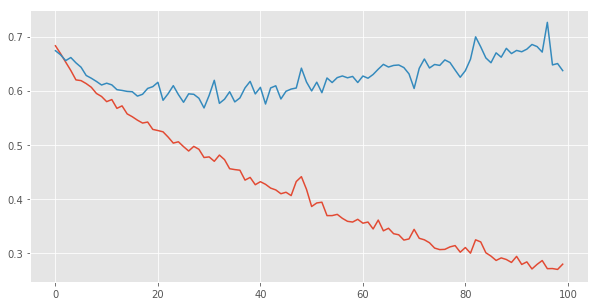

In [23]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

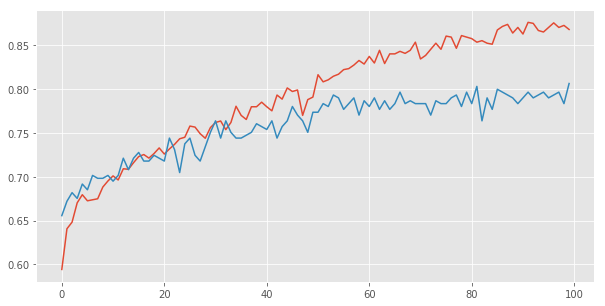

In [24]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7652859960552268
Confusion matrix, without normalization
[[117  59]
 [ 60 271]]


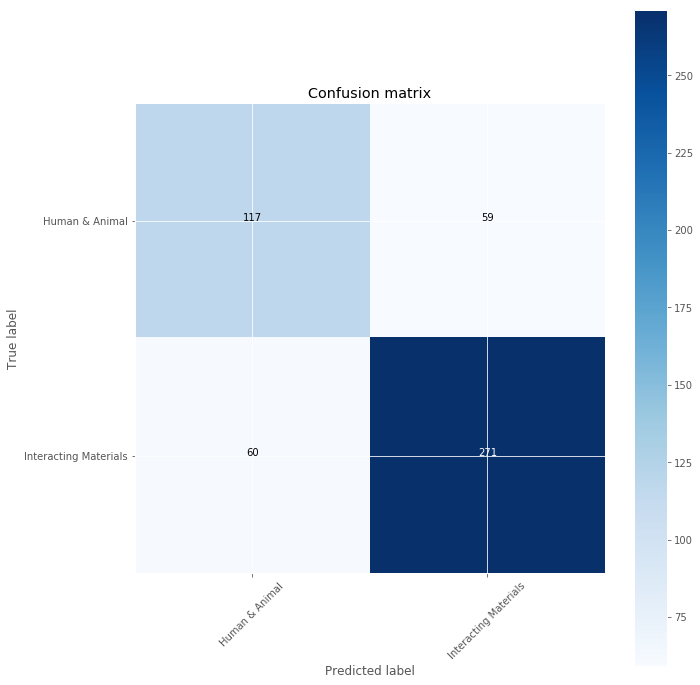

In [25]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [26]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [27]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [28]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 171, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 10, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

640/640 [==============================] - 2s 3ms/step - loss: 2.7852 - acc: 0.1156 - mean_absolute_error: 0.0975 - val_loss: 2.8032 - val_acc: 0.0531 - val_mean_absolute_error: 0.0984
Epoch 32/200
640/640 [==============================] - 2s 4ms/step - loss: 2.7710 - acc: 0.1250 - mean_absolute_error: 0.0976 - val_loss: 2.7684 - val_acc: 0.0708 - val_mean_absolute_error: 0.0980
Epoch 33/200
640/640 [==============================] - 2s 4ms/step - loss: 2.7813 - acc: 0.1109 - mean_absolute_error: 0.0973 - val_loss: 2.7426 - val_acc: 0.1150 - val_mean_absolute_error: 0.0977
Epoch 34/200
640/640 [==============================] - 3s 4ms/step - loss: 2.7770 - acc: 0.1203 - mean_absolute_error: 0.0979 - val_loss: 2.7895 - val_acc: 0.0973 - val_mean_absolute_error: 0.0983
Epoch 35/200
640/640 [==============================] - 3s 4ms/step - loss: 2.7131 - acc: 0.1266 - mean_absolute_error: 0.0970 - val_loss: 2.6893 - val_acc: 0.1416 - val_mean_absolute_error: 0.0963
Epoch 36/200
640/640 [=

640/640 [==============================] - 3s 4ms/step - loss: 2.0143 - acc: 0.3141 - mean_absolute_error: 0.0825 - val_loss: 2.2401 - val_acc: 0.2832 - val_mean_absolute_error: 0.0837
Epoch 73/200
640/640 [==============================] - 2s 4ms/step - loss: 2.0636 - acc: 0.2734 - mean_absolute_error: 0.0837 - val_loss: 2.2063 - val_acc: 0.2832 - val_mean_absolute_error: 0.0845
Epoch 74/200
640/640 [==============================] - 3s 4ms/step - loss: 2.0782 - acc: 0.2984 - mean_absolute_error: 0.0839 - val_loss: 2.2738 - val_acc: 0.3274 - val_mean_absolute_error: 0.0867
Epoch 75/200
640/640 [==============================] - 2s 4ms/step - loss: 1.9865 - acc: 0.3172 - mean_absolute_error: 0.0819 - val_loss: 2.2517 - val_acc: 0.3186 - val_mean_absolute_error: 0.0852
Epoch 76/200
640/640 [==============================] - 3s 4ms/step - loss: 2.0410 - acc: 0.2828 - mean_absolute_error: 0.0841 - val_loss: 2.2145 - val_acc: 0.2832 - val_mean_absolute_error: 0.0852
Epoch 77/200
640/640 [=

640/640 [==============================] - 2s 4ms/step - loss: 1.7065 - acc: 0.3844 - mean_absolute_error: 0.0740 - val_loss: 2.2530 - val_acc: 0.3097 - val_mean_absolute_error: 0.0789
Epoch 114/200
640/640 [==============================] - 2s 4ms/step - loss: 1.7088 - acc: 0.4219 - mean_absolute_error: 0.0746 - val_loss: 2.0883 - val_acc: 0.3628 - val_mean_absolute_error: 0.0771
Epoch 115/200
640/640 [==============================] - 3s 4ms/step - loss: 1.6639 - acc: 0.4547 - mean_absolute_error: 0.0720 - val_loss: 2.1146 - val_acc: 0.3628 - val_mean_absolute_error: 0.0795
Epoch 116/200
640/640 [==============================] - 2s 4ms/step - loss: 1.5961 - acc: 0.4516 - mean_absolute_error: 0.0725 - val_loss: 2.1817 - val_acc: 0.3540 - val_mean_absolute_error: 0.0780
Epoch 117/200
640/640 [==============================] - 3s 5ms/step - loss: 1.6130 - acc: 0.4359 - mean_absolute_error: 0.0715 - val_loss: 2.1670 - val_acc: 0.3717 - val_mean_absolute_error: 0.0772
Epoch 118/200
640/6

640/640 [==============================] - 3s 4ms/step - loss: 1.2115 - acc: 0.5594 - mean_absolute_error: 0.0579 - val_loss: 2.1507 - val_acc: 0.4159 - val_mean_absolute_error: 0.0692
Epoch 155/200
640/640 [==============================] - 3s 4ms/step - loss: 1.2061 - acc: 0.5922 - mean_absolute_error: 0.0565 - val_loss: 2.0943 - val_acc: 0.4513 - val_mean_absolute_error: 0.0690
Epoch 156/200
640/640 [==============================] - 3s 4ms/step - loss: 1.1932 - acc: 0.5891 - mean_absolute_error: 0.0570 - val_loss: 2.0737 - val_acc: 0.3894 - val_mean_absolute_error: 0.0697
Epoch 157/200
640/640 [==============================] - 2s 4ms/step - loss: 1.1427 - acc: 0.6234 - mean_absolute_error: 0.0542 - val_loss: 2.1514 - val_acc: 0.3982 - val_mean_absolute_error: 0.0694
Epoch 158/200
640/640 [==============================] - 2s 4ms/step - loss: 1.1853 - acc: 0.5969 - mean_absolute_error: 0.0551 - val_loss: 2.0832 - val_acc: 0.4425 - val_mean_absolute_error: 0.0681
Epoch 159/200
640/6

640/640 [==============================] - 3s 4ms/step - loss: 1.0046 - acc: 0.6453 - mean_absolute_error: 0.0456 - val_loss: 2.1914 - val_acc: 0.3894 - val_mean_absolute_error: 0.0674
Epoch 196/200
640/640 [==============================] - 3s 4ms/step - loss: 0.9230 - acc: 0.6875 - mean_absolute_error: 0.0460 - val_loss: 2.1948 - val_acc: 0.4159 - val_mean_absolute_error: 0.0666
Epoch 197/200
640/640 [==============================] - 3s 4ms/step - loss: 0.9222 - acc: 0.7172 - mean_absolute_error: 0.0448 - val_loss: 2.4568 - val_acc: 0.4159 - val_mean_absolute_error: 0.0676
Epoch 198/200
640/640 [==============================] - 2s 4ms/step - loss: 0.9503 - acc: 0.6703 - mean_absolute_error: 0.0455 - val_loss: 2.3650 - val_acc: 0.4336 - val_mean_absolute_error: 0.0656
Epoch 199/200
640/640 [==============================] - 3s 4ms/step - loss: 0.9922 - acc: 0.6672 - mean_absolute_error: 0.0458 - val_loss: 2.3103 - val_acc: 0.4071 - val_mean_absolute_error: 0.0666
Epoch 200/200
640/6

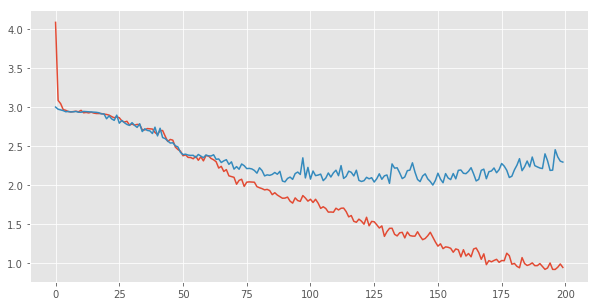

In [29]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

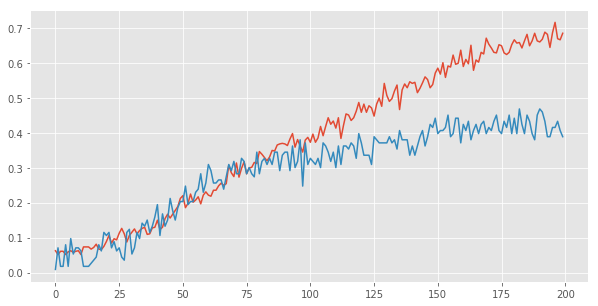

In [30]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5185185185185185
Confusion matrix, without normalization
[[ 8  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 1  1  0  2  0  0  1  0  0  0  0  0  0  1  0  1  0  0  1]
 [ 0  0  1  0 11  0  1  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 2  2  0  0  0  4  0  0  1  0  0  0  1  1  0  0  0  1  2]
 [ 3  1  0  2  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  6  0  0  1  0  0  0  0  0  0  3  2]
 [ 0  0  0  0  0  0  0  0  5  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  8  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  0  0  8  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  1  0  0  0  0  6  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  9  0  0  0  0]
 [ 0  0  1  0  0  0  3  0  0  1  0  0  0 

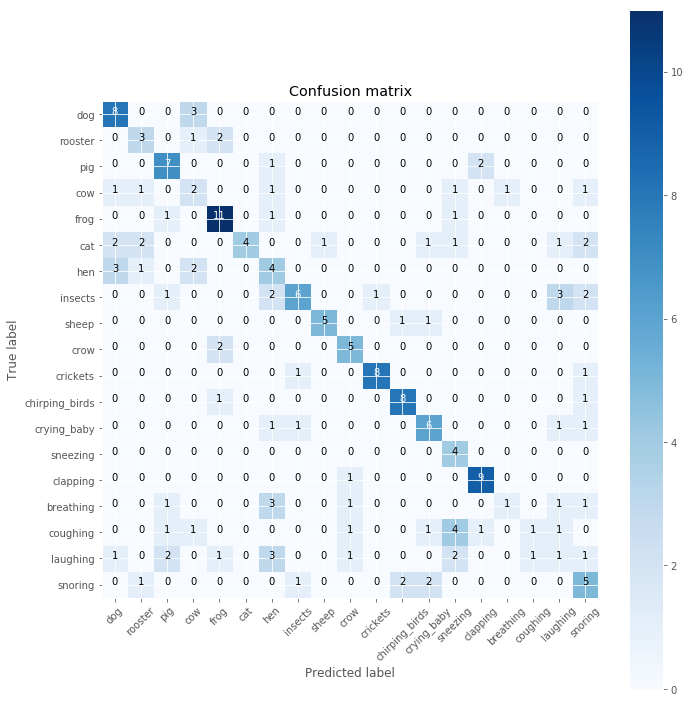

In [31]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [32]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [33]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [34]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_5 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 171, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 10, 16)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 9, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               36992     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Epoch 31/200
1082/1082 [==============================] - 3s 3ms/step - loss: 2.4166 - acc: 0.1996 - mean_absolute_error: 0.0563 - val_loss: 2.2489 - val_acc: 0.2552 - val_mean_absolute_error: 0.0547
Epoch 32/200
1082/1082 [==============================] - 3s 3ms/step - loss: 2.4921 - acc: 0.1996 - mean_absolute_error: 0.0562 - val_loss: 2.4745 - val_acc: 0.1719 - val_mean_absolute_error: 0.0568
Epoch 33/200
1082/1082 [==============================] - 4s 4ms/step - loss: 2.4385 - acc: 0.2033 - mean_absolute_error: 0.0565 - val_loss: 2.2650 - val_acc: 0.2708 - val_mean_absolute_error: 0.0547
Epoch 34/200
1082/1082 [==============================] - 3s 3ms/step - loss: 2.3430 - acc: 0.2357 - mean_absolute_error: 0.0555 - val_loss: 2.2312 - val_acc: 0.2396 - val_mean_absolute_error: 0.0541
Epoch 35/200
1082/1082 [==============================] - 4s 3ms/step - loss: 2.2951 - acc: 0.2412 - mean_absolute_error: 0.0544 - val_loss: 2.3238 - val_acc: 0.1979 - val_mean_absolute_error: 0.0540


Epoch 72/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.7641 - acc: 0.3900 - mean_absolute_error: 0.0471 - val_loss: 1.9740 - val_acc: 0.3333 - val_mean_absolute_error: 0.0483
Epoch 73/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.8276 - acc: 0.3882 - mean_absolute_error: 0.0471 - val_loss: 1.9445 - val_acc: 0.3177 - val_mean_absolute_error: 0.0483
Epoch 74/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.7412 - acc: 0.4011 - mean_absolute_error: 0.0469 - val_loss: 1.8834 - val_acc: 0.3333 - val_mean_absolute_error: 0.0475
Epoch 75/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.7303 - acc: 0.4150 - mean_absolute_error: 0.0467 - val_loss: 1.9601 - val_acc: 0.3333 - val_mean_absolute_error: 0.0478
Epoch 76/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.6981 - acc: 0.4298 - mean_absolute_error: 0.0455 - val_loss: 2.0838 - val_acc: 0.3073 - val_mean_absolute_error: 0.0480


Epoch 113/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.4340 - acc: 0.4991 - mean_absolute_error: 0.0400 - val_loss: 1.9928 - val_acc: 0.3698 - val_mean_absolute_error: 0.0449
Epoch 114/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.4120 - acc: 0.5194 - mean_absolute_error: 0.0405 - val_loss: 2.1740 - val_acc: 0.2917 - val_mean_absolute_error: 0.0466
Epoch 115/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.4730 - acc: 0.4861 - mean_absolute_error: 0.0406 - val_loss: 1.9326 - val_acc: 0.3906 - val_mean_absolute_error: 0.0443
Epoch 116/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.4387 - acc: 0.5009 - mean_absolute_error: 0.0408 - val_loss: 1.9480 - val_acc: 0.4271 - val_mean_absolute_error: 0.0441
Epoch 117/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.4179 - acc: 0.5009 - mean_absolute_error: 0.0404 - val_loss: 2.1685 - val_acc: 0.3490 - val_mean_absolute_error: 0.

Epoch 154/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.2729 - acc: 0.5573 - mean_absolute_error: 0.0368 - val_loss: 2.0978 - val_acc: 0.3958 - val_mean_absolute_error: 0.0434
Epoch 155/200
1082/1082 [==============================] - 4s 3ms/step - loss: 1.3342 - acc: 0.5591 - mean_absolute_error: 0.0375 - val_loss: 2.2005 - val_acc: 0.3698 - val_mean_absolute_error: 0.0447
Epoch 156/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.2350 - acc: 0.5555 - mean_absolute_error: 0.0364 - val_loss: 2.1581 - val_acc: 0.3646 - val_mean_absolute_error: 0.0439
Epoch 157/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.2440 - acc: 0.5749 - mean_absolute_error: 0.0355 - val_loss: 2.2335 - val_acc: 0.3646 - val_mean_absolute_error: 0.0441
Epoch 158/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.3216 - acc: 0.5564 - mean_absolute_error: 0.0363 - val_loss: 2.1049 - val_acc: 0.3854 - val_mean_absolute_error: 0.

Epoch 195/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.0054 - acc: 0.6423 - mean_absolute_error: 0.0300 - val_loss: 2.2590 - val_acc: 0.3854 - val_mean_absolute_error: 0.0414
Epoch 196/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.0015 - acc: 0.6386 - mean_absolute_error: 0.0307 - val_loss: 2.2091 - val_acc: 0.3854 - val_mean_absolute_error: 0.0418
Epoch 197/200
1082/1082 [==============================] - 4s 4ms/step - loss: 0.9862 - acc: 0.6488 - mean_absolute_error: 0.0300 - val_loss: 2.3194 - val_acc: 0.3802 - val_mean_absolute_error: 0.0417
Epoch 198/200
1082/1082 [==============================] - 4s 4ms/step - loss: 1.1125 - acc: 0.6091 - mean_absolute_error: 0.0322 - val_loss: 2.2499 - val_acc: 0.3854 - val_mean_absolute_error: 0.0421
Epoch 199/200
1082/1082 [==============================] - 4s 3ms/step - loss: 1.0891 - acc: 0.6100 - mean_absolute_error: 0.0314 - val_loss: 2.0707 - val_acc: 0.4062 - val_mean_absolute_error: 0.

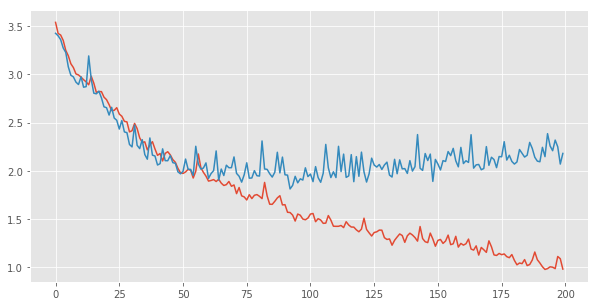

In [35]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

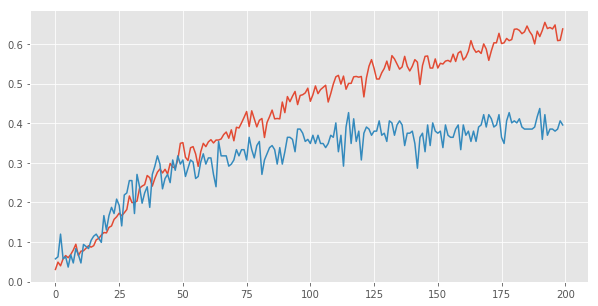

In [36]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.3667711598746082
Confusion matrix, without normalization
[[10  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
   0  0  0  0  0  0  0]
 [ 2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  2  0
   0  0  0  1  0  0  0]
 [ 0  0  5  0  0  3  0  0  0  2  1  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  1  0  1  2  0  1  0  0  0  2  0  0  0  0
   0  0  0  0  0  2  0]
 [ 2  2  0  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  2  0
   0  5  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  2  0  0  0  0  0  0  0  5  0  0  0  0  0  1
   0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  6  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0
   0  2  1  0  0  3  0]
 [ 0  0  2  1  0  0  0  0  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  2  0  0  0  0  0  0  1  0  0 

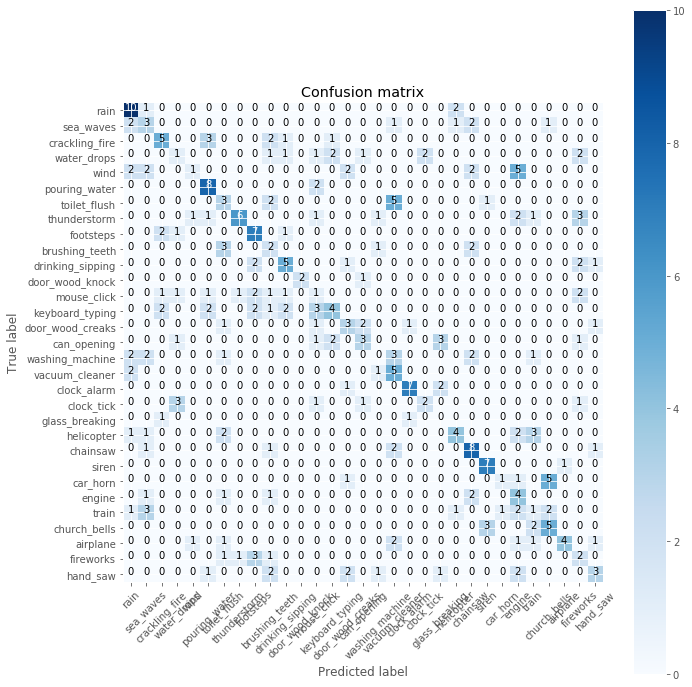

In [37]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [38]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 3.5007903575897217
	Processing Time: 3.2966067790985107
	Processing Time: 3.304152250289917
	Processing Time: 3.1736433506011963


In [39]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(10274, 1, 44100)


In [40]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(10274,)


In [41]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(10274,)


0.731360716371423
Confusion matrix, without normalization
[[2291 1536]
 [1224 5223]]


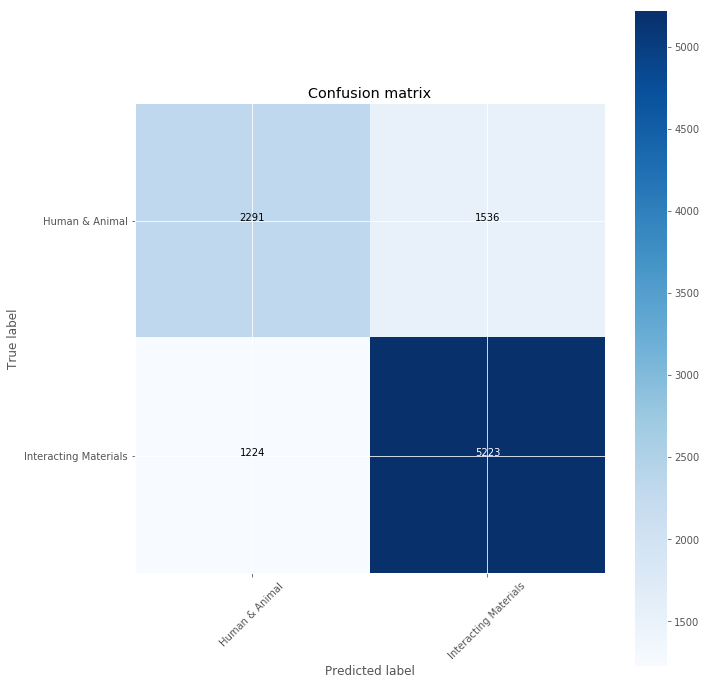

In [42]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [43]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.2848183956101385
Confusion matrix, without normalization
[[ 81   5   4  32   1   3  23   1   2   7   0   0  10  13   1   1   9   8
    0]
 [ 13  64   0  19   1   4   6   0   0   5   3   1   4  38   1   0   3   4
    1]
 [  2   2  34   2   4   1  21  30   2   5   2   6   4   8  38   2   9  20
    4]
 [ 33   5   4  45   0   3  69   4   5   1   2   1  11   6   0   2   0   5
    6]
 [ 20   3   1  14  63   1   2   3  20   9   1  16   5   5  52   0   3   5
    0]
 [ 38  42   0  19   5  17   8   0   4   7   0   3  11  15   1   0   2  10
    4]
 [ 44   6  10   6   0   5  80   7   0   0   0   1  22   2   1   4   5  12
    3]
 [ 25   0  12  13   0  12  32  29   6   4   5  13   5   9   2   5   3  18
   25]
 [ 18   2   1  13  11   3  14  20  86  16   0  12   8   4   0   1   2   6
    5]
 [ 18  12   0  33  14   1  18   2  25  70   0   4   0   1   0   1   1   4
    2]
 [  7   0   1   0   7   7   0   4   0   7  53 102   0   9   0   0   0   1
   26]
 [ 13   0   3   1   6   4   5  11   6   0  22 121 

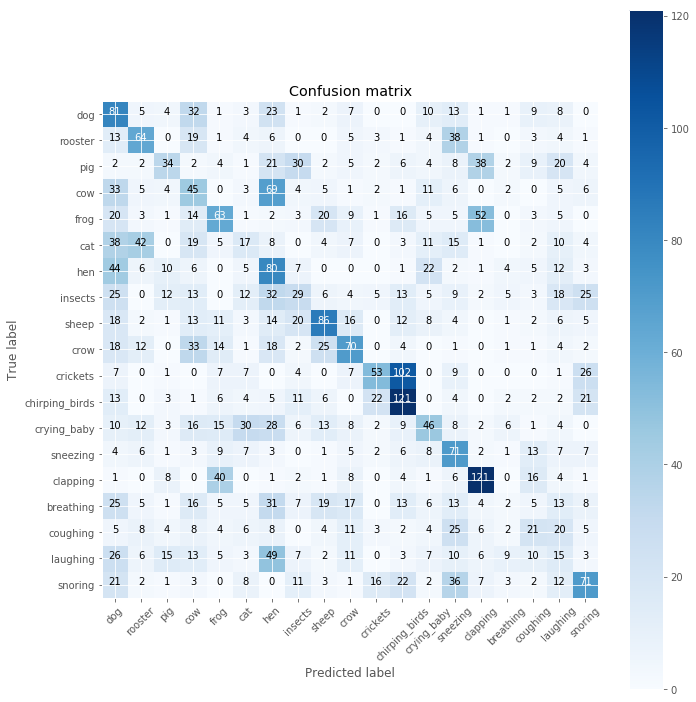

In [44]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.21188149526911743
Confusion matrix, without normalization
[[ 92  10   2   0   0   0   7   0   0   6   0   0   0   0   1   0   0  33
    0   0   0  48   7   0   2   4   0   0   6   0   6]
 [ 20  62   0   0   0   0   5   0   0   2   0   0   0   0   0   0   0  46
    0   0   2   3  52   0   0   7   7   0  10   1   6]
 [  0   0  58   4   0  63   6   0   5  16   1   0   7  21   4   5   1   0
    2   2   2   2   9   0   0   2   0   0   0   1   6]
 [  0   0  10  16   0  16   0   3  16   0  25   1  19  19   4  10   0   0
    6   3  18   0   0   1   0   7   0   0   2  11   1]
 [  0   9   0   0   5   0   1   6   0   2   0   0   0   0   0   0   0   0
    1   0   0   2  14  24   2  63  62  20  11   0   2]
 [  0   0  35   1   0  84   3   0   2  10   2   0   6  14  10   1   0   0
   20   0  14   0   4   0   0   1   0   3   0   0   2]
 [ 28   6   2   1   1   4  40   1   2  32   2   3   1   1  10   0   5  16
    0   0   0  20   7   0   0  13   0   0  13   1  13]
 [  0   0   5   1   4   5   1  49   0

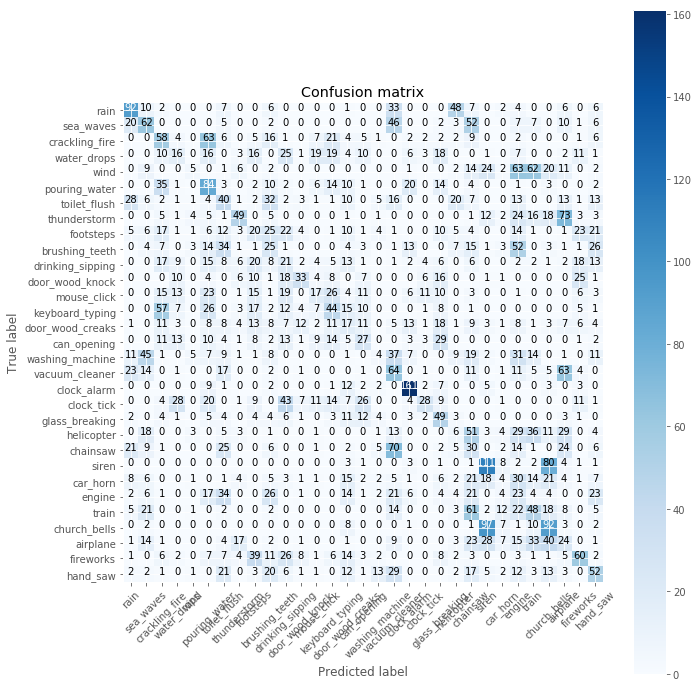

In [45]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [46]:
clas.predict_proba(X)

array([[1.3036352e-01, 8.6963648e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       ...,
       [9.9999249e-01, 7.5133157e-06],
       [8.5750800e-01, 1.4249200e-01],
       [4.0199310e-01, 5.9800690e-01]], dtype=float32)

# Testing Accuracy of Single File

In [47]:
data_iloc = 1

In [48]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [49]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.007961511611938477


In [50]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

7/7 [==============================] - 0s 1ms/step


In [51]:
np.average(pred_prob, axis=0)

array([0.72549105, 0.27450898], dtype=float32)

In [52]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

7/7 [==============================] - 0s 3ms/step


In [53]:
np.average(pred_prob, axis=0)

array([1.32775222e-08, 1.41996470e-05, 1.90957915e-04, 4.78299589e-05,
       2.79227160e-02, 1.14146121e-06, 4.42468763e-06, 2.61271782e-02,
       2.81519111e-04, 2.48775119e-03, 8.48669559e-04, 8.19678366e-01,
       2.62098056e-05, 2.60340981e-04, 1.17429197e-01, 7.02865873e-05,
       2.02963944e-03, 1.09308516e-04, 2.47027539e-03], dtype=float32)

In [54]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [55]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [56]:
predictions = []
full_targets = []
start_time = time.time()

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    b = Counter(pred)
    if b.most_common(1)[0][0] == 0:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.008049249649047852
	Processing Time: 0.004272937774658203
	Processing Time: 0.0048923492431640625
	Processing Time: 0.005079984664916992
	Processing Time: 0.05930352210998535
	Processing Time: 0.004518747329711914
	Processing Time: 0.004156589508056641
	Processing Time: 0.0044956207275390625
	Processing Time: 0.0044689178466796875
	Processing Time: 0.003894329071044922
	Processing Time: 0.030676603317260742
	Processing Time: 0.004620790481567383
	Processing Time: 0.004873037338256836
	Processing Time: 0.00641942024230957
	Processing Time: 0.0038635730743408203
	Processing Time: 0.00444483757019043
	Processing Time: 0.0044574737548828125
	Processing Time: 0.004558086395263672
	Processing Time: 0.004445314407348633
	Processing Time: 0.004411220550537109
	Processing Time: 0.004496574401855469
	Processing Time: 0.0044939517974853516
	Processing Time: 0.0044612884521484375
	Processing Time: 0.00720977783203125
	Processing Time: 0.0044901371002197266
	Processing Time: 0.0

	Processing Time: 0.005595684051513672
	Processing Time: 0.005942821502685547
	Processing Time: 0.008276939392089844
	Processing Time: 0.005619049072265625
	Processing Time: 0.005004405975341797
	Processing Time: 0.006172895431518555
	Processing Time: 0.004978656768798828
	Processing Time: 0.005171775817871094
	Processing Time: 0.005738496780395508
	Processing Time: 0.005312442779541016
	Processing Time: 0.004922151565551758
	Processing Time: 0.0045621395111083984
	Processing Time: 0.006989479064941406
	Processing Time: 0.0056531429290771484
	Processing Time: 0.007834911346435547
	Processing Time: 0.0047566890716552734
	Processing Time: 0.00455021858215332
	Processing Time: 0.004392862319946289
	Processing Time: 0.00603032112121582
	Processing Time: 0.004814863204956055
	Processing Time: 0.00532221794128418
	Processing Time: 0.005666017532348633
	Processing Time: 0.005463600158691406
	Processing Time: 0.0046787261962890625
	Processing Time: 0.004336357116699219
	Processing Time: 0.0045

	Processing Time: 0.005213737487792969
	Processing Time: 0.006264686584472656
	Processing Time: 0.005751132965087891
	Processing Time: 0.005168437957763672
	Processing Time: 0.005490779876708984
	Processing Time: 0.005042552947998047
	Processing Time: 0.007877349853515625
	Processing Time: 0.0050220489501953125
	Processing Time: 0.004560947418212891
	Processing Time: 0.005169391632080078
	Processing Time: 0.0061261653900146484
	Processing Time: 0.004675388336181641
	Processing Time: 0.004792213439941406
	Processing Time: 0.005398750305175781
	Processing Time: 0.004616975784301758
	Processing Time: 0.0045697689056396484
	Processing Time: 0.005640506744384766
	Processing Time: 0.004776716232299805
	Processing Time: 0.004895687103271484
	Processing Time: 0.0050814151763916016
	Processing Time: 0.01716017723083496
	Processing Time: 0.005451202392578125
	Processing Time: 0.004647970199584961
	Processing Time: 0.007210969924926758
	Processing Time: 0.00467371940612793
	Processing Time: 0.008

	Processing Time: 0.005377769470214844
	Processing Time: 0.007177114486694336
	Processing Time: 0.0055005550384521484
	Processing Time: 0.008712291717529297
	Processing Time: 0.004787445068359375
	Processing Time: 0.005308628082275391
	Processing Time: 0.006995677947998047
	Processing Time: 0.0060155391693115234
	Processing Time: 0.0044095516204833984
	Processing Time: 0.005675554275512695
	Processing Time: 0.004714250564575195
	Processing Time: 0.005675792694091797
	Processing Time: 0.006520986557006836
	Processing Time: 0.00500178337097168
	Processing Time: 0.005364894866943359
	Processing Time: 0.004611492156982422
	Processing Time: 0.006860494613647461
	Processing Time: 0.005286216735839844
	Processing Time: 0.0040760040283203125
	Processing Time: 0.004083156585693359
	Processing Time: 0.005346775054931641
	Processing Time: 0.004585981369018555
	Processing Time: 0.0056688785552978516
	Processing Time: 0.004281520843505859
	Processing Time: 0.004656076431274414
	Processing Time: 0.0

	Processing Time: 0.004990577697753906
	Processing Time: 0.005108356475830078
	Processing Time: 0.004910469055175781
	Processing Time: 0.005074739456176758
	Processing Time: 0.014495611190795898
	Processing Time: 0.00829768180847168
	Processing Time: 0.0047800540924072266
	Processing Time: 0.004858732223510742
	Processing Time: 0.004809856414794922
	Processing Time: 0.007216215133666992
	Processing Time: 0.005259037017822266
	Processing Time: 0.00573277473449707
	Processing Time: 0.004338502883911133
	Processing Time: 0.004295825958251953
	Processing Time: 0.006087779998779297
	Processing Time: 0.005138397216796875
	Processing Time: 0.004322528839111328
	Processing Time: 0.005264759063720703
	Processing Time: 0.004338502883911133
	Processing Time: 0.004328727722167969
	Processing Time: 0.004345893859863281
	Processing Time: 0.004329204559326172
	Processing Time: 0.005325794219970703
	Processing Time: 0.004689455032348633
	Processing Time: 0.004359722137451172
	Processing Time: 0.004309

	Processing Time: 0.006345272064208984
	Processing Time: 0.0043179988861083984
	Processing Time: 0.004305601119995117
	Processing Time: 0.00509953498840332
	Processing Time: 0.004347562789916992
	Processing Time: 0.004264116287231445
	Processing Time: 0.004556894302368164
	Processing Time: 0.004131793975830078
	Processing Time: 0.005103111267089844
	Processing Time: 0.003916263580322266
	Processing Time: 0.00406336784362793
	Processing Time: 0.004304170608520508
	Processing Time: 0.004349708557128906
	Processing Time: 0.004304409027099609
	Processing Time: 0.0059049129486083984
	Processing Time: 0.004329681396484375
	Processing Time: 0.004378557205200195
	Processing Time: 0.006068229675292969
	Processing Time: 0.02923583984375
	Processing Time: 0.004912614822387695
	Processing Time: 0.0041713714599609375
	Processing Time: 0.004312276840209961
	Processing Time: 0.004306793212890625
	Processing Time: 0.004319190979003906
	Processing Time: 0.0041654109954833984
	Processing Time: 0.0042455

	Processing Time: 0.005074501037597656
	Processing Time: 0.003929853439331055
	Processing Time: 0.004372596740722656
	Processing Time: 0.004252195358276367
	Processing Time: 0.004335880279541016
	Processing Time: 0.004331111907958984
	Processing Time: 0.005505561828613281
	Processing Time: 0.004240274429321289
	Processing Time: 0.004244804382324219
	Processing Time: 0.005136013031005859
	Processing Time: 0.004279375076293945
	Processing Time: 0.005291938781738281
	Processing Time: 0.004835844039916992
	Processing Time: 0.00432276725769043
	Processing Time: 0.0042574405670166016
	Processing Time: 0.004296302795410156
	Processing Time: 0.004312992095947266
	Processing Time: 0.0046656131744384766
	Processing Time: 0.00429844856262207
	Processing Time: 0.004311323165893555
	Processing Time: 0.005837678909301758
	Processing Time: 0.004282712936401367
	Processing Time: 0.004255533218383789
	Processing Time: 0.00449824333190918
	Processing Time: 0.0042552947998046875
	Processing Time: 0.01053

	Processing Time: 0.007303953170776367
	Processing Time: 0.0043468475341796875
	Processing Time: 0.004328012466430664
	Processing Time: 0.006074666976928711
	Processing Time: 0.004351615905761719
	Processing Time: 0.004346132278442383
	Processing Time: 0.005313396453857422
	Processing Time: 0.0043981075286865234
	Processing Time: 0.004021644592285156
	Processing Time: 0.005499124526977539
	Processing Time: 0.004408359527587891
	Processing Time: 0.004347562789916992
	Processing Time: 0.004339456558227539
	Processing Time: 0.004317522048950195
	Processing Time: 0.004373073577880859
	Processing Time: 0.004335880279541016
	Processing Time: 0.004345417022705078
	Processing Time: 0.004767179489135742
	Processing Time: 0.0043332576751708984
	Processing Time: 0.006139278411865234
	Processing Time: 0.0040242671966552734
	Processing Time: 0.0052013397216796875
	Processing Time: 0.012995719909667969
	Processing Time: 0.004540443420410156
	Processing Time: 0.004473686218261719
	Processing Time: 0.

	Processing Time: 0.00429534912109375
	Processing Time: 0.0042591094970703125
	Processing Time: 0.005087614059448242
	Processing Time: 0.004265785217285156
	Processing Time: 0.004940509796142578
	Processing Time: 0.004262685775756836
	Processing Time: 0.004258632659912109
	Processing Time: 0.005995750427246094
	Processing Time: 0.004309177398681641
	Processing Time: 0.00426483154296875
	Processing Time: 0.005594491958618164
	Processing Time: 0.00425410270690918
	Processing Time: 0.004277944564819336
	Processing Time: 0.004266023635864258
	Processing Time: 0.0042667388916015625
	Processing Time: 0.005586147308349609
	Processing Time: 0.004241466522216797
	Processing Time: 0.004264354705810547
	Processing Time: 0.006329774856567383
	Processing Time: 0.004263877868652344
	Processing Time: 0.004281282424926758
	Processing Time: 0.004291057586669922
	Processing Time: 0.004240274429321289
	Processing Time: 0.004653215408325195
	Processing Time: 0.005245685577392578
	Processing Time: 0.004934

	Processing Time: 0.005192995071411133
	Processing Time: 0.0043294429779052734
	Processing Time: 0.004257678985595703
	Processing Time: 0.004664421081542969
	Processing Time: 0.004292488098144531
	Processing Time: 0.004222393035888672
	Processing Time: 0.005857229232788086
	Processing Time: 0.004250288009643555
	Processing Time: 0.004280567169189453
	Processing Time: 0.005913257598876953
	Processing Time: 0.004300117492675781
	Processing Time: 0.0056722164154052734
	Processing Time: 0.004303693771362305
	Processing Time: 0.004334449768066406
	Processing Time: 0.00527501106262207
	Processing Time: 0.0042798519134521484
	Processing Time: 0.004306793212890625
	Processing Time: 0.00570988655090332
	Processing Time: 0.0041921138763427734
	Processing Time: 0.00431370735168457
	Processing Time: 0.004770517349243164
	Processing Time: 0.004323720932006836
	Processing Time: 0.004581451416015625
	Processing Time: 0.004385471343994141
	Processing Time: 0.0043010711669921875
	Processing Time: 0.006

In [57]:
targs = np.vstack(full_targets)

0.2015
Confusion matrix, without normalization
[[22  1  1 ...  1  1  2]
 [ 3 23  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  5]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  3  8  4]
 [ 0  0  3 ...  1  0  6]]


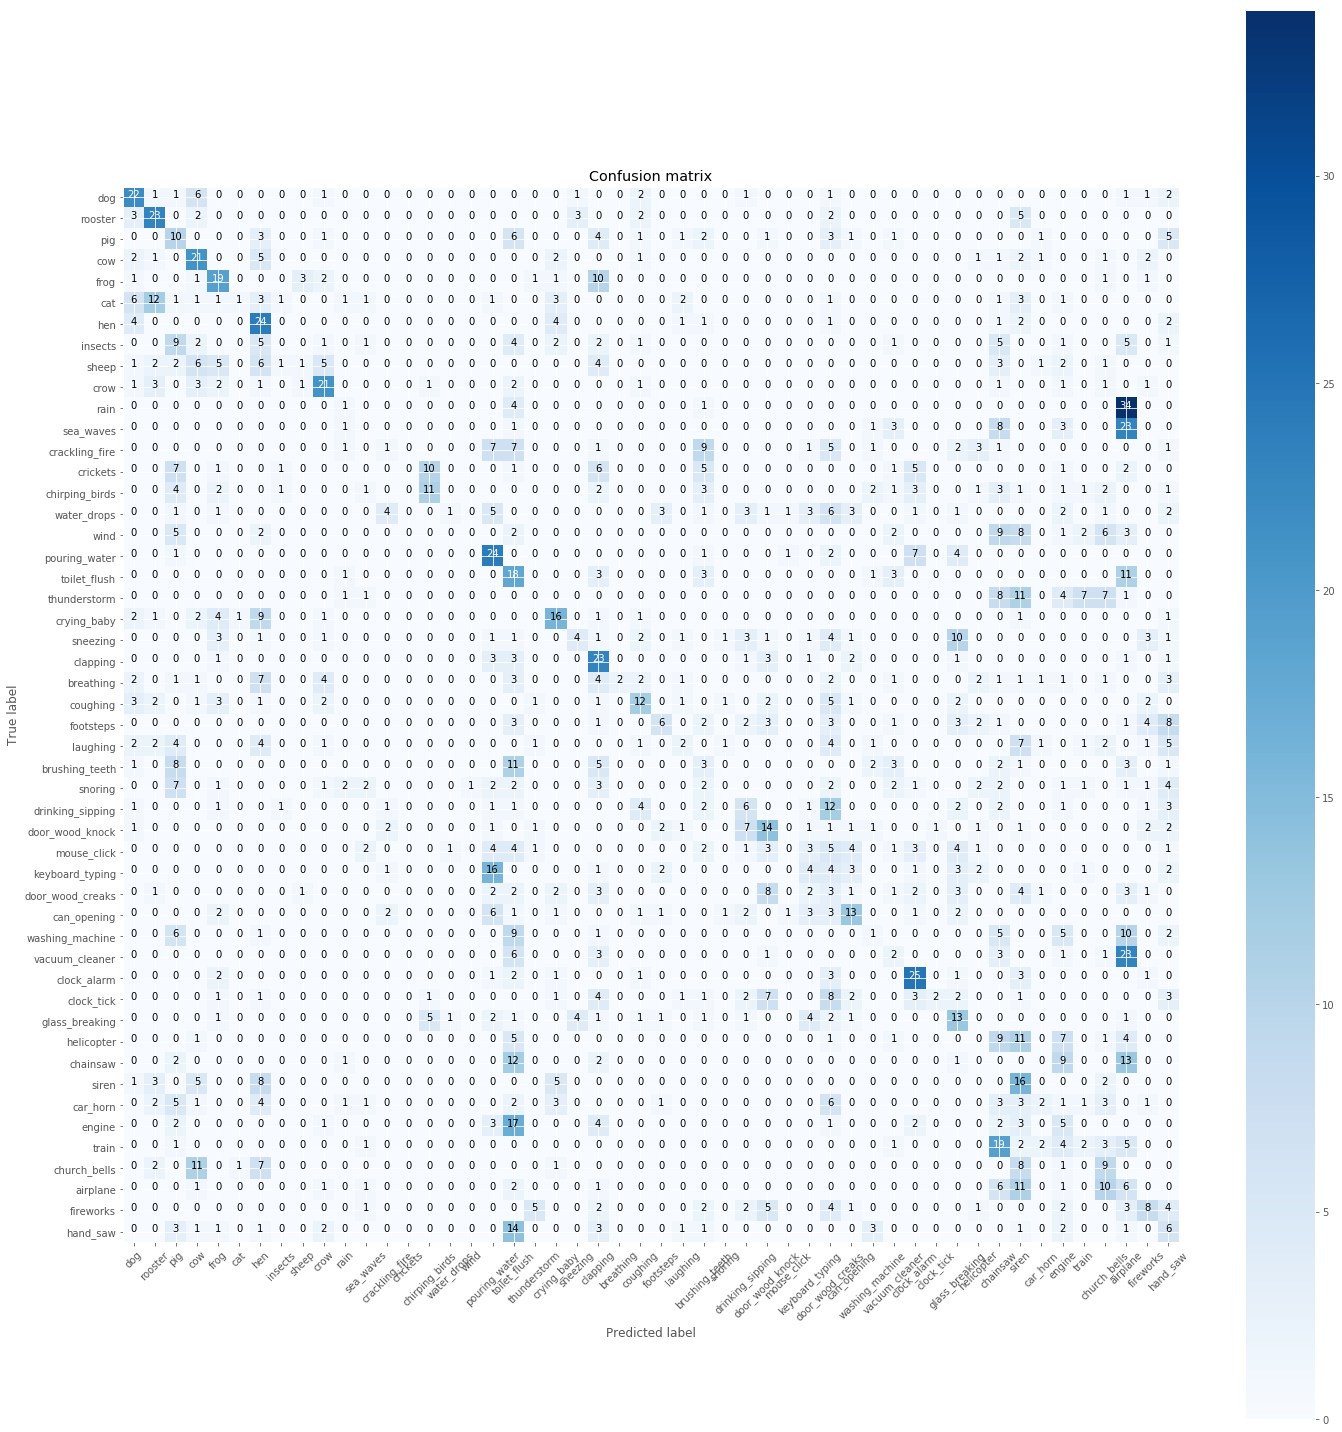

In [58]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()